- with classification
    - classification으로 1,0 구분하는거랑 regression 둘다 만들어두고,
    - classification=1인 경우에 regression 결과값, classification=0인 경우에 0 넣는 방법

# Library Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

from base import gc_collect_all, setdiff
from filesystem_utils import mkdir
from graph import abline
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [2]:
gc_collect_all()

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
def return_unique_columns(data):
    unique_info = data.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    return unique_cols

In [5]:
class CFG:
    SEED = 42
    TARGET = 'price(원/kg)'
    KEY_FEATURES = ['item','corporation','location']

<br></br>

# Data

## Data Load

In [6]:
# item:
#     TG : 감귤
#     BC : 브로콜리
#     RD : 무
#     CR : 당근
#     CB : 양배추

In [7]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')
trade_df = pd.read_csv('./data/international_trade.csv')

In [8]:
print(train_df.shape)
train_df.head()

(59397, 7)


,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [9]:
print(test_df.shape)
test_df.head()

(1092, 5)


,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J


In [10]:
print(trade_df.shape)
trade_df.head()

(1274, 7)


,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


<br>

## Preprocessing

In [11]:
def add_week(weekend):
    week = 1
    week_list = []
    for weekend in weekend:
        if weekend==1:
            week+=1
        week_list.append(week)
    return week_list

In [12]:
def preprocessing(data):
    d = data.copy()
    
    d = d.sort_values(CFG.KEY_FEATURES).reset_index(drop=True)
    
    # (1) datetime format
    d['timestamp'] = d['timestamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
    
    # (2) delete unuse features
    unuse_features = ['ID','supply(kg)']
    unuse_features = list(set(d.columns)&set(unuse_features))
    d.drop(unuse_features,axis=1,inplace=True)

    return d

In [13]:
def merge_trade_data(data,trade_data):
    d, td = data.copy(), trade_data.copy()
    
    ### trade data preprocessing
    
    # # (1) 흑자여부
    td.drop('무역수지',axis=1,inplace=True)

    # (2) 품목명 수정 및 필요없는 품목 정보 제거
    replace_dict = {
        '감귤': 'TG',
        '꽃양배추와 브로콜리(broccoli)': 'BC',
        '당근': 'CR',
        '순무': 'RD',
        '양배추': 'CB',
    }
    td['품목명'] = td['품목명'].map(replace_dict)
    td.dropna(subset=['품목명'], inplace=True)
    
    ### merge data
    d['기간'] = [str(t)[:7] for t in d['timestamp']]
    merged = pd.merge(d,td.rename(columns={'품목명':'item'}),how='left',on=['기간','item'])
    merged.drop('기간',axis=1,inplace=True)
    
    # 2023년 3월 데이터는 trade 데이터에 없으므로 가장 최근의 값으로 채워줌
    merged.ffill(inplace=True)
    
    return merged

In [14]:
def feature_engineering(data):
    d = data.copy()
    
    # (1) date columns
    d['year']       = d.timestamp.dt.year
    d['month']      = d.timestamp.dt.month
    d['day']        = d.timestamp.dt.day
    d['weekday']    = d.timestamp.dt.weekday
    d['weekend']    = d.timestamp.dt.weekday.isin([5,6]).astype(int)
    d['week']       = add_week(d['weekend'])

    # (2) is holiday & is dayoff
    holiday_list = get_holiday(d['year'].unique())
    d['is_holiday'] = d.timestamp.isin(holiday_list).astype(int)
    d['is_dayoff']  = ((d.is_holiday==1) | (d.weekend==1)).astype(int)
    
    # (3) 무역수지, 흑자여부 추가
    d['무역수지'] = d['수출 금액'] - d['수입 금액']
    d['흑자여부'] = np.where(d['무역수지']>0,1,0)
    
    return d

In [15]:
# from copy import deepcopy
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import SimpleImputer, IterativeImputer

# def imputation(train_data,test_data,method):
#     if method in ['mean','median']:
#         base_imputer = SimpleImputer(missing_values=np.nan, strategy=method)
#     elif method=='mice':
#         base_imputer = IterativeImputer(random_state=CFG.SEED)
#     else:
#         raise ValueError(f"Unknown method={method}")
    
#     numerical_cols = train_data.select_dtypes(include=[int,float]).columns.tolist()
#     numerical_cols = list(set(numerical_cols)-set([CFG.TARGET]))
    
#     train_list = []
#     test_list = []
#     for (item,corporation,location),tr in tqdm(train_data.groupby(['item','corporation','location'])):
#         te = test_data[(test_data['item']==item) & (test_data['corporation']==corporation) & (test_data['location']==location)]
#         imputer = deepcopy(base_imputer)
#         tr[numerical_cols] = imputer.fit_transform(tr[numerical_cols])
#         train_list.append(tr)
#         if len(te)>0:
#             te[numerical_cols] = imputer.transform(te[numerical_cols])
#             test_list.append(te)
        
#     new_train = pd.concat(train_list,axis=0)
#     new_test = pd.concat(test_list,axis=0)
    
#     return new_train.sort_index(), new_test.sort_index()

In [16]:
train_df = preprocessing(train_df)
train_df = merge_trade_data(train_df, trade_df)
train_df = feature_engineering(train_df)

test_df = preprocessing(test_df)
test_df = merge_trade_data(test_df, trade_df)
test_df = feature_engineering(test_df)

In [17]:
train_df.head()

,timestamp,item,corporation,location,price(원/kg),수출 중량,수출 금액,수입 중량,수입 금액,year,month,day,weekday,weekend,week,is_holiday,is_dayoff,무역수지,흑자여부
0,2019-01-01,BC,A,J,0.0,160.0,1.0,638913.0,563.0,2019,1,1,1,0,1,1,1,-562.0,0
1,2019-01-02,BC,A,J,0.0,160.0,1.0,638913.0,563.0,2019,1,2,2,0,1,0,0,-562.0,0
2,2019-01-03,BC,A,J,2559.0,160.0,1.0,638913.0,563.0,2019,1,3,3,0,1,0,0,-562.0,0
3,2019-01-04,BC,A,J,2425.0,160.0,1.0,638913.0,563.0,2019,1,4,4,0,1,0,0,-562.0,0
4,2019-01-05,BC,A,J,2097.0,160.0,1.0,638913.0,563.0,2019,1,5,5,1,2,0,1,-562.0,0


<br></br>

# EDA

In [18]:
# (1) key별 건수
train_df.groupby(CFG.KEY_FEATURES).size().head()

item  corporation  location
BC    A            J           1523
                   S           1523
      B            J           1523
                   S           1523
      C            J           1523
dtype: int64

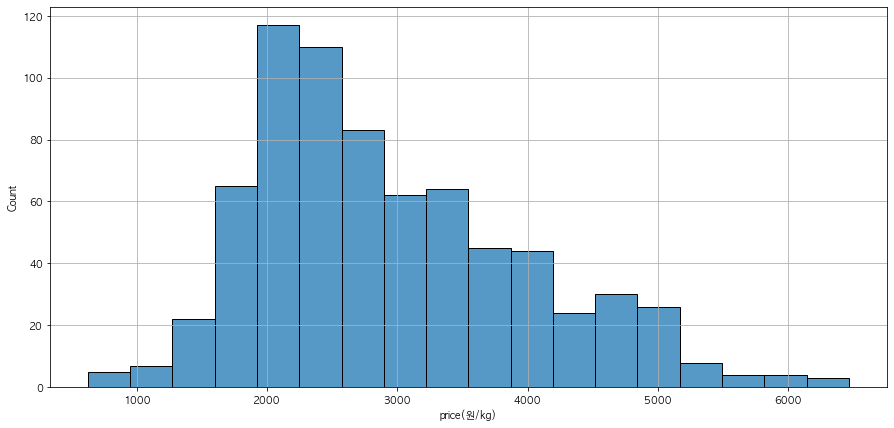

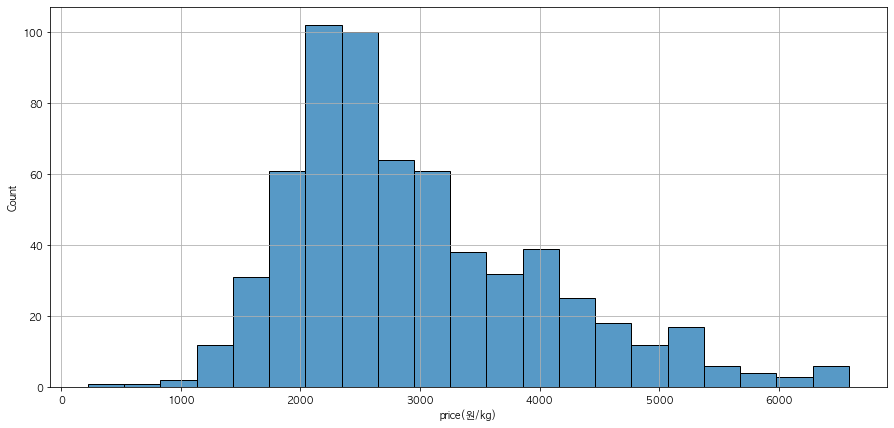

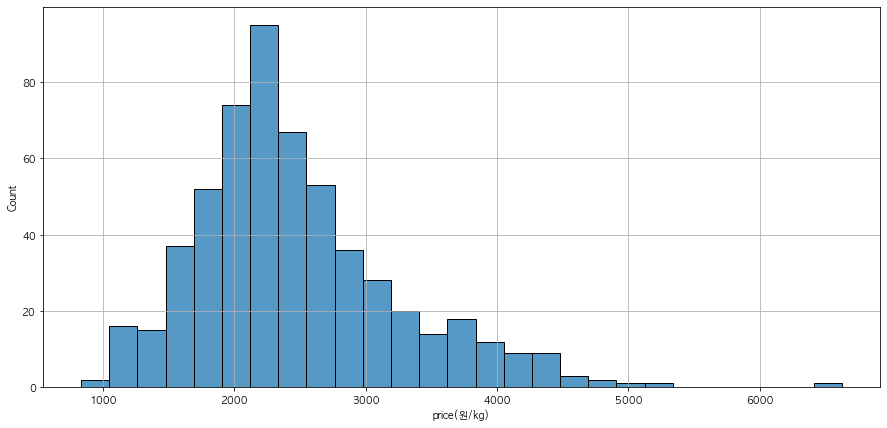

In [19]:
# (2) 품목/법인/지역에 따른 가격 히스토그램
# train_df.groupby(CFG.KEY_FEATURES)[CFG.TARGET].agg(Min=np.min,Max=np.max)
for i,(idx,d) in enumerate(train_df.groupby(CFG.KEY_FEATURES)):
    if i<3:
        target = d[CFG.TARGET]
        target = target[target!=0]
        
        plt.figure(figsize=(15,7))
        sns.histplot(target)
        plt.grid()
        plt.show()

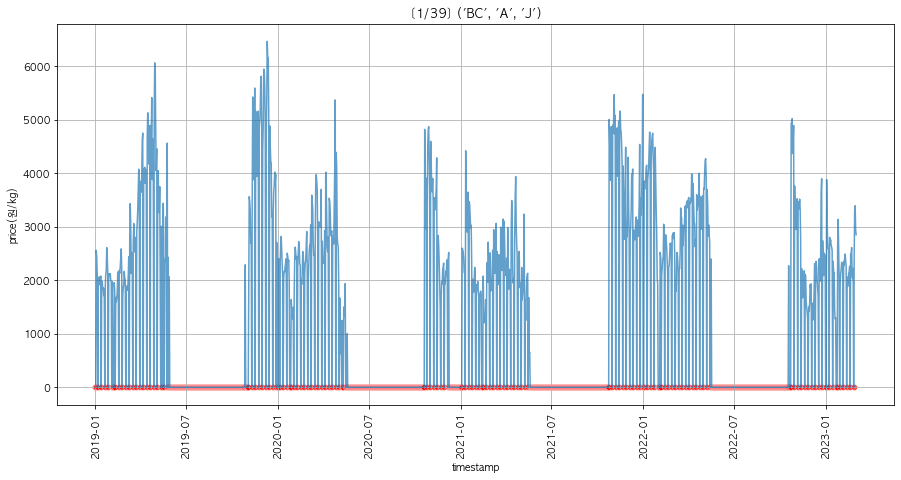

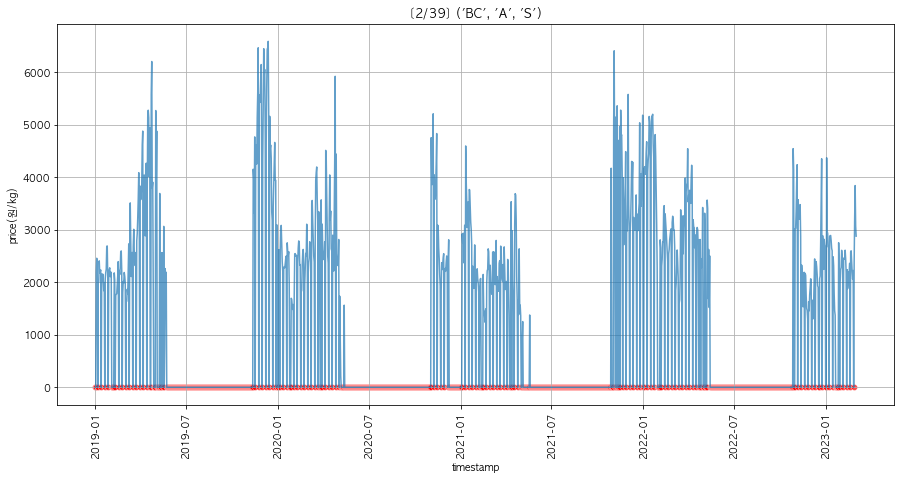

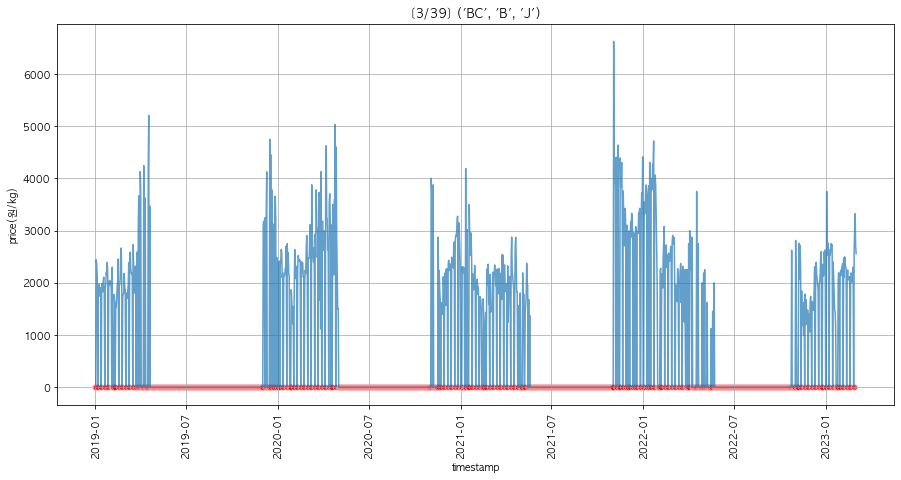

In [20]:
# (3) 품목/법인/지역에 따른 일별 가격변동
grp_data = train_df.groupby(CFG.KEY_FEATURES)
for i,(idx,d) in enumerate(grp_data):
    if i<3:
        plt.figure(figsize=(15,7))
        sns.lineplot(x=d['timestamp'],y=d[CFG.TARGET],alpha=0.7)
        if np.where(d[CFG.TARGET]==0,1,0).sum()>0:
            x=d['timestamp'][d[CFG.TARGET]==0]
            y=d[CFG.TARGET] [d[CFG.TARGET]==0]
            sns.scatterplot(x=x,y=y,color='red',alpha=0.7)
        plt.xticks(rotation=90)
        plt.grid()
        plt.title(f'[{i+1}/{len(grp_data)}] {idx}')
        plt.show()

<br></br>

# Modeling

In [21]:
mkdir('./mc')

In [75]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import optuna

In [87]:
def get_seg_data(data,item,corporation,location):
    d = data.copy()
    d = d[(d['item']==item) & (d['corporation']==corporation) & (d['location']==location)]
    d['cap'] = d[CFG.TARGET].max()
    return d

In [88]:
models = []
i=0

grps = train_df[CFG.KEY_FEATURES].drop_duplicates().values
pbar = tqdm(grps)
for item,corp,loc in pbar:
    i+=1
    str_i = str(i).zfill(len(str(len(grps))))
    progress = '[{}/{}] item:{}, corporation:{}, location:{}'.format(str_i,len(grps),item,corp,loc)
    pbar.set_description(progress)
    
    tr_data = get_seg_data(train_df,item,corp,loc)
    te_data = get_seg_data(test_df ,item,corp,loc)
    
    adfsd

[01/39] item:BC, corporation:A, location:J:   0%|          | 0/39 [00:00<?, ?it/s]


KeyError: 'price(원/kg)'

In [113]:
def objective(trial, data):
    g = {
        'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.001, 10),
        'seasonality_prior_scale': trial.suggest_loguniform('seasonality_prior_scale', 0.001, 10),
        'holidays_prior_scale': trial.suggest_uniform('holidays_prior_scale', 0.1, 0.5),
        'yearly_seasonality': trial.suggest_categorical('yearly_seasonality', [True, False]),
        'weekly_seasonality': trial.suggest_categorical('weekly_seasonality', [True, False]),
        'daily_seasonality': trial.suggest_categorical('daily_seasonality', [False, True]),
        'n_changepoints': trial.suggest_categorical('n_changepoints', [True, False]),
        #'fourier_order': trial.suggest_int('fourier_order', 1, 5),
        #'period': trial.suggest_uniform('period', 0.1, 0.5),
    }
    
    holidays = data[data.is_holiday==1][['timestamp']].reset_index(drop=True)
    holidays = holidays.rename(columns={'timestamp':'ds'}).assign(holiday='KOR_Holidays')
    
    columns = ['timestamp',CFG.TARGET]
    if g['growth']=='logistic':
        columns += ['cap']
    d = data[columns].rename(columns={'timestamp':'ds',CFG.TARGET:'y'})
    
    tscv = TimeSeriesSplit(n_splits=5, test_size=28)
    
    rmse_list = []
    for tr_idx, val_idx in tscv.split(d):
        train_data, val_data = d.iloc[tr_idx], d.iloc[val_idx]
        
        model = Prophet(
            changepoint_prior_scale = g['changepoint_prior_scale'],
            seasonality_prior_scale = g['seasonality_prior_scale'],
            holidays_prior_scale = g['holidays_prior_scale'],
            seasonality_mode = g['seasonality_mode'],
            growth = g['growth'],
            yearly_seasonality = g['yearly_seasonality'],
            weekly_seasonality = g['weekly_seasonality'],
            daily_seasonality = g['daily_seasonality'],
            n_changepoints = g['n_changepoints'],
            holidays=holidays,
            interval_width=0.95,
        )
        model.add_country_holidays(country_name='KOR')
        #model.add_seasonality(name='add_seasonality',period=g['period'],fourier_order=g['fourier_order'])
        model.fit(train_data)
        
        pred = model.predict(val_data.drop('y',axis=1))['yhat'].values
        true = val_data['y'].values
        
        rmse = mean_squared_error(true,pred)**0.5
        rmse_list.append(rmse)
    
    return np.mean(rmse_list)

In [114]:
import logging
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

In [115]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, tr_data), n_trials=100)

[I 2023-11-10 01:39:20,623] A new study created in memory with name: no-name-8f170900-313d-4bb7-8600-2a2291978337
[I 2023-11-10 01:39:24,133] Trial 0 finished with value: 3743.1132596074285 and parameters: {'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.824287957562929, 'seasonality_prior_scale': 0.9038318567552664, 'holidays_prior_scale': 0.20232544331435698, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'n_changepoints': False}. Best is trial 0 with value: 3743.1132596074285.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
[I 2023-11-10 01:39:29,965] Trial 1 finished with value: 1327.5948464347243 and parameters: {'growth': 'linear', 'seasonality_mode': 'mul

In [119]:
g = study.best_params

In [120]:
data = tr_data.copy()

In [121]:
holidays = data[data.is_holiday==1][['timestamp']].reset_index(drop=True)
holidays = holidays.rename(columns={'timestamp':'ds'}).assign(holiday='KOR_Holidays')

columns = ['timestamp',CFG.TARGET]
if g['growth']=='logistic':
    columns += ['cap']
d = data[columns].rename(columns={'timestamp':'ds',CFG.TARGET:'y'})

model = Prophet(
    changepoint_prior_scale = g['changepoint_prior_scale'],
    seasonality_prior_scale = g['seasonality_prior_scale'],
    holidays_prior_scale = g['holidays_prior_scale'],
    seasonality_mode = g['seasonality_mode'],
    growth = g['growth'],
    yearly_seasonality = g['yearly_seasonality'],
    weekly_seasonality = g['weekly_seasonality'],
    daily_seasonality = g['daily_seasonality'],
    n_changepoints = g['n_changepoints'],
    holidays=holidays,
    interval_width=0.95,
)
model.add_country_holidays(country_name='KOR')
#model.add_seasonality(name='add_seasonality',period=g['period'],fourier_order=g['fourier_order'])
model.fit(train_data)

In [163]:
holidays = data[data.is_holiday==1][['timestamp']].reset_index(drop=True)
holidays = holidays.rename(columns={'timestamp':'ds'}).assign(holiday='KOR_Holidays')

model = Prophet()
# model.add_country_holidays(country_name='KOR')
#model.add_seasonality(name='add_seasonality',period=g['period'],fourier_order=g['fourier_order'])
model.fit(train_data)

In [164]:
test_data = te_data[['timestamp']].rename(columns={'timestamp':'ds'})
test_data['cap'] = d.cap.values[0]

In [165]:
pred = model.predict(test_data)['yhat']

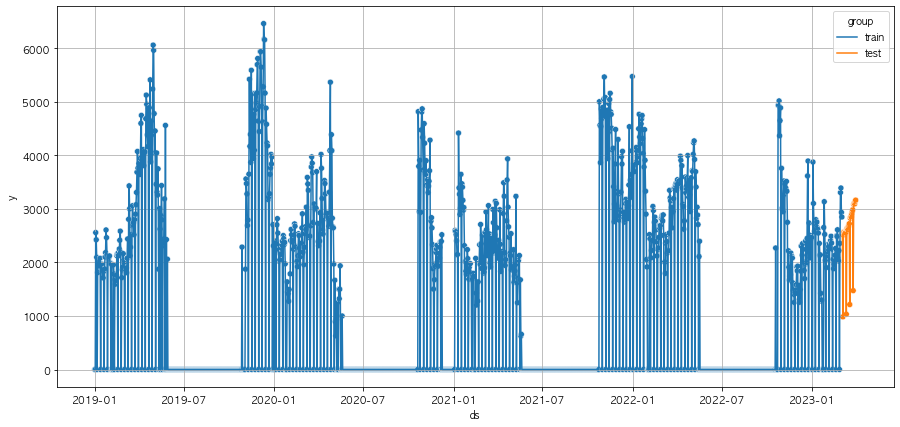

In [168]:
plot_df = pd.DataFrame({
    'ds' : d['ds'].tolist() + test_data['ds'].tolist(),
    'y' : d['y'].tolist() + pred.tolist(),
    'group' : ['train']*len(d) + ['test']*len(pred),
})
# plot_df = plot_df[plot_df.y!=0]

plt.figure(figsize=(15,7))
sns.lineplot(x=plot_df.ds,y=plot_df.y,hue=plot_df.group)
sns.scatterplot(x=plot_df.ds,y=plot_df.y,hue=plot_df.group,legend=False)
plt.grid()
plt.show()

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['answer'] = te_pred_df.pred
submit.to_csv('./out/submit_seg_1.csv',index=False)
submit.head()